In [1]:
# Change current work path to root
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import random

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import torch 

from model import Model
from network import VanillaLSTM, SeqT2v, GreedySeqT2v
from utils import sliding_window, train_test_split

In [3]:
# Set up random seed
# Randomly generated seed list
seed_list = [11, 78, 70, 14, 85, 16, 8, 80, 66, 0]

seed = seed_list[9]
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Dataset

Source: https://www.kaggle.com/danofer/time2vec-water-levels/data

In [4]:
data = pd.read_csv('data/venezia_water_level.csv')

# Date Correction
data['datetime'] = pd.date_range(data.loc[0, 'datetime'], periods=data.shape[0], freq='H')

# Set level_change as target
data['level_change'] = data['level'].diff()
data = data[1:].reset_index(drop=True)

data['timestamp'] = data.index
data['datetime'] = pd.to_datetime(data['datetime'])

# Create date features
data['year'] = data['datetime'].dt.year - data['datetime'].dt.year.min()
data['monthofyear'] = data['datetime'].dt.month
data['weekofyear'] = data['datetime'].dt.isocalendar().week 
data['dayofyear'] = data['datetime'].dt.dayofyear
data['dayofmonth'] = data['datetime'].dt.day
data['dayofweek'] = data['datetime'].dt.weekday
data['hourofday'] = data['datetime'].dt.hour

# SARIMA

In [5]:
model = SARIMAX(data[:12024]['level_change'], order=(0, 1, 2), seasonal_order=(0, 1, 2, 4)).fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.38362D+00    |proj g|=  2.20429D-01

At iterate    5    f=  2.99722D+00    |proj g|=  2.91080D-01

At iterate   10    f=  2.75120D+00    |proj g|=  1.23974D-01

At iterate   15    f=  2.73937D+00    |proj g|=  2.04756D-03

At iterate   20    f=  2.73577D+00    |proj g|=  1.28260D-02

At iterate   25    f=  2.73298D+00    |proj g|=  5.82289D-03

At iterate   30    f=  2.73278D+00    |proj g|=  4.80838D-04

At iterate   35    f=  2.73277D+00    |proj g|=  4.82965D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [6]:
# Calculate Test MSE & MAPE
pred_y = model.predict(start=10024, end=12023).values
test_y = data.loc[10024:12023, 'level_change']

mse_0 = mean_squared_error(test_y, pred_y)
mape_0 = mean_absolute_percentage_error(test_y[test_y != 0], pred_y[test_y != 0])

mse_0, mape_0

(17.221161719693708, 0.6369470438754452)

# Vanilla LSTM Model

In [7]:
# Target = 'level_change'
# Value feature = 'level_change'
# Time feature = 'timestamp'

x1, _, x2, y = sliding_window(
    data[:12024], value_feature_cols=['level_change'], time_feature_cols=['timestamp'], 
    target_col='level_change', window_size=24
)

(train_x1, train_x2, train_y), (test_x1, test_x2, test_y) = train_test_split(
    x1, x2, y, test_size=2000, verbose=True)

Train Set Shape: [(10000, 24, 1), (10000, 1), (10000,)]
Test Set Shape: [(2000, 24, 1), (2000, 1), (2000,)]


In [8]:
# Define network & model
network_1 = VanillaLSTM(1, 8)
model_1 = Model(network_1)

# Train
model_1.train(train_x1, y=train_y)

Epoch: 0, Train Loss: 121.08462524414062, Valid Loss: 122.85517883300781
Epoch: 100, Train Loss: 4.171662330627441, Valid Loss: 4.944946765899658
Epoch: 200, Train Loss: 3.592505931854248, Valid Loss: 4.482879161834717
Epoch: 300, Train Loss: 3.602975606918335, Valid Loss: 4.433193206787109
Epoch: 400, Train Loss: 3.4585671424865723, Valid Loss: 4.335369110107422
Epoch: 500, Train Loss: 3.2873172760009766, Valid Loss: 4.202159881591797
Epoch: 600, Train Loss: 3.2230112552642822, Valid Loss: 4.20779275894165
Epoch: 700, Train Loss: 3.271629810333252, Valid Loss: 4.227484226226807
Epoch: 800, Train Loss: 3.2285473346710205, Valid Loss: 4.233666896820068
Epoch   849: reducing learning rate of group 0 to 5.0000e-03.
Epoch: 900, Train Loss: 3.1051604747772217, Valid Loss: 4.19932746887207
Epoch   950: reducing learning rate of group 0 to 2.5000e-03.
Best Train Loss: 3.170037269592285, Best Valid Loss: 4.159849643707275


In [9]:
# Calculate Test MSE & MAPE
pred_y = model_1.predict(test_x1).cpu().detach().numpy()

mse_1 = mean_squared_error(test_y, pred_y)
mape_1 = mean_absolute_percentage_error(test_y[test_y != 0], pred_y[test_y != 0])

mse_1, mape_1

(4.8856726653496585, 0.3275376857007673)

# T2V LSTM Model

In [10]:
# Define network & model
network_2 = SeqT2v(1, 4, 1, 8)
model_2 = Model(network_2)

# Train
model_2.train(train_x1, train_x2, y=train_y)

Epoch: 0, Train Loss: 194.32977294921875, Valid Loss: 374.1012878417969
Epoch: 100, Train Loss: 5.122559547424316, Valid Loss: 6.11958122253418
Epoch: 200, Train Loss: 3.9069817066192627, Valid Loss: 4.969475269317627
Epoch: 300, Train Loss: 3.5990326404571533, Valid Loss: 4.600197792053223
Epoch: 400, Train Loss: 3.5982139110565186, Valid Loss: 4.4529242515563965
Epoch: 500, Train Loss: 3.5001847743988037, Valid Loss: 4.311883449554443
Epoch: 600, Train Loss: 3.3792805671691895, Valid Loss: 4.187927722930908
Epoch: 700, Train Loss: 3.763528347015381, Valid Loss: 4.437900543212891
Epoch   776: reducing learning rate of group 0 to 5.0000e-03.
Epoch: 800, Train Loss: 3.2980637550354004, Valid Loss: 4.149262428283691
Epoch   885: reducing learning rate of group 0 to 2.5000e-03.
Epoch: 900, Train Loss: 3.2568752765655518, Valid Loss: 4.158884048461914
Best Train Loss: 3.2334394454956055, Best Valid Loss: 4.09626579284668


In [11]:
# Calculate Test MSE & MAPE
pred_y = model_2.predict((test_x1, test_x2)).cpu().detach().numpy()

mse_2 = mean_squared_error(test_y, pred_y)
mape_2 = mean_absolute_percentage_error(test_y[test_y != 0], pred_y[test_y != 0])

mse_2, mape_2

(4.92562269697881, 0.32954066223247236)

# D2V LSTM Model

In [12]:
# Target = 'level_change'
# Value feature = 'level_change'
# Time feature = ['year', 'monthofyear', 'weekofyear', 'dayofyear', 'dayofmonth', 'dayofweek', 'hourofday']

time_feature = ['year', 'monthofyear', 'weekofyear', 'dayofyear', 'dayofmonth', 'dayofweek', 'hourofday']
x1, _, x2, y = sliding_window(
    data[:12024], value_feature_cols=['level_change'], time_feature_cols=time_feature, 
    target_col='level_change', window_size=24
)

(train_x1, train_x2, train_y), (test_x1, test_x2, test_y) = train_test_split(
    x1, x2, y, test_size=2000, verbose=True)

Train Set Shape: [(10000, 24, 1), (10000, 7), (10000,)]
Test Set Shape: [(2000, 24, 1), (2000, 7), (2000,)]


In [13]:
# Define network & model
network_3 = SeqT2v(1, 4, 1, 8, time_input_channel=7)
model_3 = Model(network_3)

# Train
model_3.train(train_x1, train_x2, y=train_y)

Epoch: 0, Train Loss: 122.14720153808594, Valid Loss: 124.47808074951172
Epoch: 100, Train Loss: 4.285887241363525, Valid Loss: 5.397552967071533
Epoch: 200, Train Loss: 3.6265757083892822, Valid Loss: 4.467106342315674
Epoch: 300, Train Loss: 3.4874215126037598, Valid Loss: 4.353309631347656
Epoch: 400, Train Loss: 3.380211591720581, Valid Loss: 4.358351230621338
Epoch: 500, Train Loss: 3.365750312805176, Valid Loss: 4.333825588226318
Epoch   536: reducing learning rate of group 0 to 5.0000e-03.
Epoch: 600, Train Loss: 3.2405595779418945, Valid Loss: 4.278585910797119
Epoch   666: reducing learning rate of group 0 to 2.5000e-03.
Epoch: 700, Train Loss: 3.207587242126465, Valid Loss: 4.279028415679932
Epoch   767: reducing learning rate of group 0 to 1.2500e-03.
Epoch: 800, Train Loss: 3.189455509185791, Valid Loss: 4.278314113616943
Epoch   868: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 900, Train Loss: 3.181838274002075, Valid Loss: 4.284836292266846
Best Train Loss: 3.

In [14]:
# Calculate Test MSE & MAPE
pred_y = model_3.predict((test_x1, test_x2)).cpu().detach().numpy()

mse_3 = mean_squared_error(test_y, pred_y)
mape_3 = mean_absolute_percentage_error(test_y[test_y != 0], pred_y[test_y != 0])

mse_3, mape_3

(5.077550880131548, 0.3383235515796692)

# Greedy D2V LSTM Model

In [15]:
# Embedding Train
frozen_t2v=[]

# Feed one time feature at one time
for i, col in enumerate(time_feature):
    print(f"=== Train time feature '{col}' ====")
    network_4 = GreedySeqT2v(1, 4, 1, 8, frozen_t2v)
    model_4 = Model(network_4, max_epoch=500)
    model_4.train(train_x1, train_x2[:, :i + 1], y=train_y)
    
    # Freeze T2V layer except last run
    if i < len(time_feature) - 1:
        frozen_t2v = network_4.freeze()

=== Train time feature 'year' ====
Epoch: 0, Train Loss: 118.75877380371094, Valid Loss: 120.46845245361328
Epoch: 100, Train Loss: 4.632436752319336, Valid Loss: 5.7033491134643555
Epoch: 200, Train Loss: 3.624258279800415, Valid Loss: 4.543216705322266
Epoch: 300, Train Loss: 3.4407176971435547, Valid Loss: 4.362889289855957
Epoch: 400, Train Loss: 3.4021449089050293, Valid Loss: 4.289746284484863
Best Train Loss: 3.4153711795806885, Best Valid Loss: 4.200553894042969
=== Train time feature 'monthofyear' ====
Epoch: 0, Train Loss: 121.29766845703125, Valid Loss: 123.04508972167969
Epoch: 100, Train Loss: 5.004992961883545, Valid Loss: 6.168814659118652
Epoch: 200, Train Loss: 3.8253602981567383, Valid Loss: 4.828938007354736
Epoch: 300, Train Loss: 3.6050779819488525, Valid Loss: 4.644495964050293
Epoch: 400, Train Loss: 4.093358993530273, Valid Loss: 4.973740577697754
Best Train Loss: 3.3523612022399902, Best Valid Loss: 4.327719211578369
=== Train time feature 'weekofyear' ====
Epo

In [16]:
# Calculate Test MSE & MAPE
pred_y = model_4.predict((test_x1, test_x2)).cpu().detach().numpy()

mse_4 = mean_squared_error(test_y, pred_y)
mape_4 = mean_absolute_percentage_error(test_y[test_y != 0], pred_y[test_y != 0])

mse_4, mape_4

(4.720774383775646, 0.3263593286889228)

# Compare Performance

In [17]:
# mse_0, 
mse_1, mse_2, mse_3, mse_4

(4.8856726653496585, 4.92562269697881, 5.077550880131548, 4.720774383775646)

In [18]:
# mape_0, 
mape_1, mape_2, mape_3, mape_4

(0.3275376857007673,
 0.32954066223247236,
 0.3383235515796692,
 0.3263593286889228)

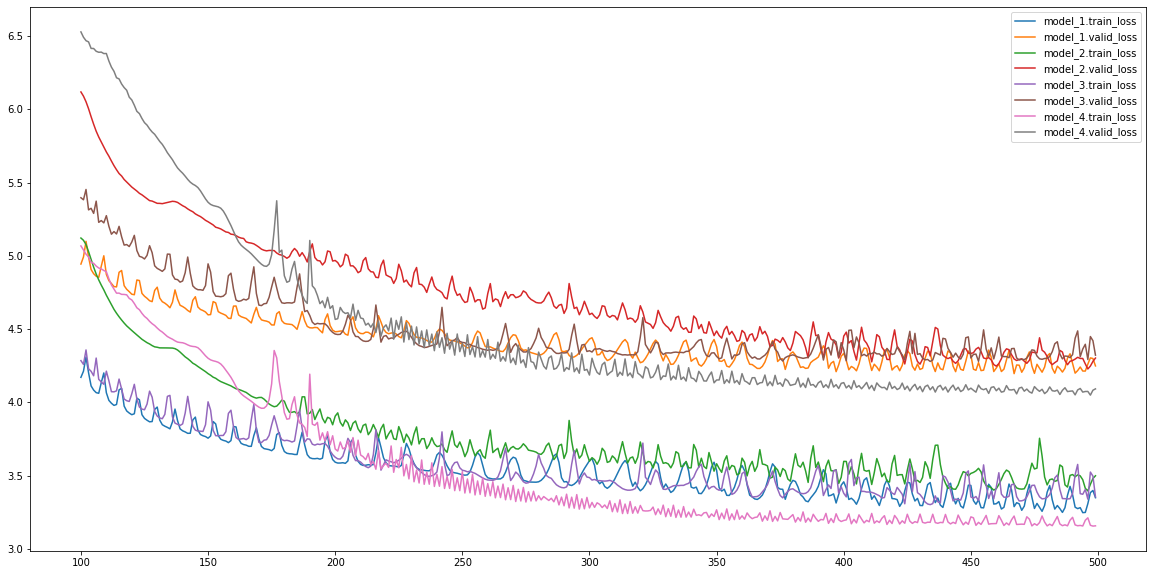

In [19]:
loss_df = pd.DataFrame(
    [model_1.train_loss, model_1.valid_loss, 
     model_2.train_loss, model_2.valid_loss, 
     model_3.train_loss, model_3.valid_loss,
     model_4.train_loss, model_4.valid_loss
    ], 
    index=['model_1.train_loss', 'model_1.valid_loss', 
           'model_2.train_loss', 'model_2.valid_loss', 
           'model_3.train_loss', 'model_3.valid_loss',
           'model_4.train_loss', 'model_4.valid_loss',
          ],
).T.iloc[100:500].plot(figsize=(20, 10))

# Summery

| Model           | MSE         | MAPE        |
| --------------- | ----------- | ----------- |
| SARIMA          | 17.221      | 0.637       |
| Vanilla LSTM    | 4.933       | 0.330       | 
| T2V LSTM        | 5.060       | 0.333       |
| D2V LSTM        | 4.918       | 0.331       |
| Greedy D2V LSTM | 4.758       | 0.324       |  

In [20]:
mse = [
    (5.029101180690823, 4.774557737022606, 4.801229607666564, 4.7106414761495365), 
    (5.037028787286126, 5.065235999778678, 4.849773796651265, 4.850822536361549),
    (4.836600547514765, 5.0842684116509975, 4.914440776097167, 4.7040738268438655),
    (5.0368858680512405, 5.42770589407046, 5.140495010724932, 4.708628486772844),
    (4.7645118510320215, 4.9030291594784545, 4.95089720990559, 4.643589505014316),
    (5.097225513959014, 4.845395550155034, 4.9347766422139685, 4.950417603412069),
    (4.834962091110494, 4.983812548909295, 4.917095661870817, 4.903228005073333),
    (4.903006889995588, 4.842143265585644, 4.833662195995231, 4.746096053203008),
    (4.9109488192942035, 5.74249625057039, 4.755621607753963, 4.637426166727294),
    (4.8856726653496585, 4.92562269697881, 5.077550880131548, 4.720774383775646),
]

np.array(mse).mean(0)

array([4.93359442, 5.05942675, 4.91755434, 4.7575698 ])

In [21]:
mape = [
    (0.329484084864702, 0.3242582503695402, 0.3238289476637886, 0.3274230576828179),
    (0.32404832635082215, 0.33330611760517703, 0.3298424019919557, 0.32165336870631206),
    (0.3262088066945903, 0.3296627223046585, 0.33128128531778306, 0.32318571062661056),
    (0.33682510551603545, 0.343025641069601, 0.3421250700518551, 0.32353452593129906),
    (0.3283001798972095, 0.3308374275877443, 0.32828806045482367, 0.316893764189099),
    (0.335935129024421, 0.3249591879090797, 0.3314286930526645, 0.33096345007166633),
    (0.3283229045316826, 0.3319864713592949, 0.3293016029872536, 0.3323952854286527),
    (0.3285522761754386, 0.32812540171336935, 0.3255661646627754, 0.32548771446326236),
    (0.333557146788149, 0.3541642719032669, 0.32714168721574804, 0.3165491165780888),
    (0.3275376857007673, 0.32954066223247236, 0.3383235515796692, 0.3263593286889228),
]

np.array(mape).mean(0)

array([0.32987716, 0.33298662, 0.33071275, 0.32444453])